In [1]:
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import time 

In [2]:
# load data 
mbd_data = pd.read_csv('./outputs/mbd_data.csv')
clusters = json.loads(open('./outputs/clusters_lr.json',"r").read())
cluster_keys = ["0","1","2","3","4","5","6","-1"]
mbd_data = mbd_data.sort_values(by=["cfips","first_day_of_month"]).reset_index(drop=True)
mbd_data.median_hh_inc.ffill(inplace=True)
mbd_data.pct_it_workers.ffill(inplace=True)

sc = MinMaxScaler()
mbd_data.median_hh_inc = sc.fit_transform( mbd_data.median_hh_inc.values.reshape(-1,1) ).reshape(-1)

cfips = mbd_data.cfips.unique()

In [3]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true)) / 2
    smape_val = np.mean(numerator / denominator)
    return smape_val

In [4]:
# Plot a county 

def plot_county(cfip):
#     cfip = clusters["-1"][0]
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))
    dates = pd.date_range(start='2019-08-01', end='2022-12-01', freq='MS')
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    # Plot the line
    ax.plot(dates, values)

    # Set the axis labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Microbusiness Density')
    ax.set_title(f'{location} ( CFIP {cfip} )  ')

    # Rotate the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Show the plot
    plt.show()

In [5]:
# Adfuller Test : Check if for any county, microbusiness density is stationary 

# cfip = clusters["-1"][1]
stationary_count = 0 
stationary_counties = []
for cfip in clusters["-1"]: 
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    p_value = adfuller(values)[1]
    if p_value < 0.01 : 
        # reject null hypothesis . So time series is stationary 
        stationary_count += 1 
        stationary_counties.append(cfip)
stationary_count, len(clusters["-1"])


(20, 180)

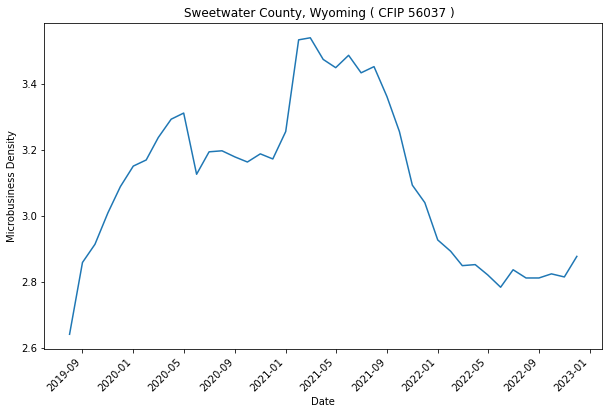

In [6]:
# for cfip in stationary_counties:
plot_county(cfip) 

array([0.48895898, 0.48895898, 0.48895898, 0.46556431, 0.46556431,
       0.44951037, 0.43345642, 0.43345642, 0.43345642, 0.44951037,
       0.40134853, 0.40134853, 0.40134853, 0.41740248, 0.40134853])

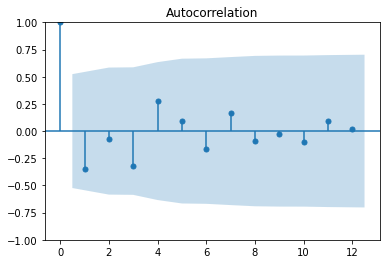

In [7]:
# ARIMA model fit 
cfip = 47095
# cfip = 55099
values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
plot_acf(np.diff(values[-15:],1))
# plt.show()
values[-15:]

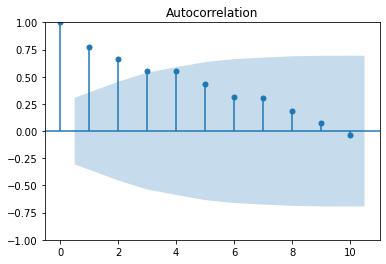

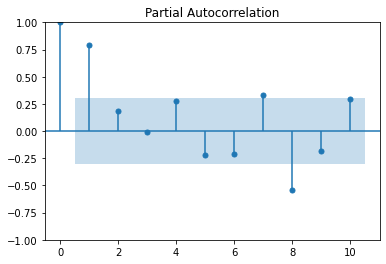

In [8]:
#  Determine values for p, d, and q
acf = sm.graphics.tsa.plot_acf(values, lags=10)
pacf = sm.graphics.tsa.plot_pacf(values, lags=10)

In [9]:
adfuller(values[-15:-2])

(-0.8074379163019558,
 0.8169274663472377,
 0,
 12,
 {'1%': -4.137829282407408,
  '5%': -3.1549724074074077,
  '10%': -2.7144769444444443},
 -39.998655822206224)

In [10]:
p = 1
d = 0
q = 1
# Create and fit the ARIMA model
model = sm.tsa.ARIMA(values[-15:-3], order=(p, d, q))
results = model.fit()


In [11]:
smape(results.predict()[1:],values[-14:-3])

0.02756059370077594

In [12]:
results.forecast(steps=3)

array([0.40740406, 0.41239445, 0.41676239])

In [13]:
smape(values[-3:],results.forecast(steps=3))

0.02157569058361719

In [14]:
results.predict()

array([0.44741366, 0.48335477, 0.48355063, 0.48355828, 0.46402823,
       0.46323825, 0.44980413, 0.43585856, 0.43529447, 0.43527165,
       0.4486729 , 0.40900846])

In [15]:
results.forecast(steps=20)

array([0.40740406, 0.41239445, 0.41676239, 0.42058551, 0.42393178,
       0.42686067, 0.42942424, 0.43166806, 0.433632  , 0.43535099,
       0.43685556, 0.43817247, 0.43932512, 0.440334  , 0.44121705,
       0.44198995, 0.44266645, 0.44325857, 0.44377683, 0.44423045])

In [16]:
pred = np.concatenate([results.predict()[1:],results.forecast(2)])

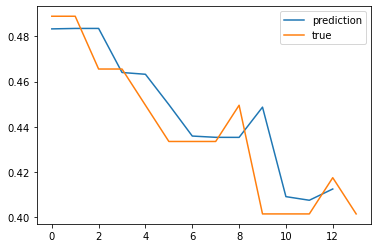

In [17]:
plt.plot(pred,label='prediction')
plt.plot(values[-14:],label='true')
plt.legend()
plt.show()


In [18]:
data = values[-15:-2]
model = sm.tsa.statespace.SARIMAX(data, order=(1, 1, 0), seasonal_order=(0, 0, 0, 3))
results = model.fit()
results.predict()

array([0.        , 0.48895898, 0.48895898, 0.48895898, 0.46861633,
       0.46556431, 0.45160473, 0.43555078, 0.43345642, 0.43345642,
       0.44741601, 0.40763161, 0.40134853])

In [19]:
data

array([0.48895898, 0.48895898, 0.48895898, 0.46556431, 0.46556431,
       0.44951037, 0.43345642, 0.43345642, 0.43345642, 0.44951037,
       0.40134853, 0.40134853, 0.40134853])

In [20]:
results.predict()

array([0.        , 0.48895898, 0.48895898, 0.48895898, 0.46861633,
       0.46556431, 0.45160473, 0.43555078, 0.43345642, 0.43345642,
       0.44741601, 0.40763161, 0.40134853])

### Fit ARIMA model on bad performing counties 

In [21]:
results = {}

In [398]:
def do_task(p,d,q,values):
    train, test = values[:-2], values[-2:]
    model = sm.tsa.ARIMA(train, order=(p, d, q))
    results = model.fit()
    train_smape = smape(results.predict()[1:],train[1:])
    test_smape = smape(results.forecast(2),test)
    return train_smape, test_smape

def get_best_params(data):
    is_stationary = adfuller(data)[1] > 0.02

    best_params = []
    train_least_smape = np.inf
    test_least_smape = np.inf
    for p in range(0,3): 
        for q in range(0,3): 
            if is_stationary: 
                train_smape, test_smape = do_task(p,0,q,data)
                if test_smape < test_least_smape: 
                    train_least_smape = train_smape
                    test_least_smape = test_smape
                    best_params = [p,0,q]
            else: 
                for d in range(0,2):
                    train_smape, test_smape = do_task(p,d,q,data)
                    if test_smape < test_least_smape: 
                        train_least_smape = train_smape
                        test_least_smape = test_smape
                        best_params = [p,d,q]

    return best_params,train_least_smape, test_least_smape

df = pd.DataFrame(columns = ["cluster_id","cfips", "train_original_smape","val_original_smape", "train_clipped_smape","val_clipped_smape"])

start = time.time()
# cfip = 47095


for cluster_id in ["-1","4","5","6","0"]:
    results[cluster_id] = {}
    print("Cluster ",cluster_id)
    for cfip in tqdm(clusters[cluster_id]): 
        # Case 1 : Using full data, No clipping
        data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
        best_params1,train_least_smape1, test_least_smape1 = get_best_params(data)

        # Cast 2 : After clipping 
        data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values[-15:] # use last 15 values only
        best_params2,train_least_smape2, test_least_smape2 = get_best_params(data)
#         best_params2,least_smape2
        
        results[cluster_id][cfip] = {
            "train_original_smape" : train_least_smape1,
            "val_original_smape": test_least_smape1,
            "train_clipped_smape": train_least_smape2,
            "val_clipped_smape": test_least_smape2,
            "best_params_original" : best_params1,
            "best_params_clipped": best_params2
        }
        df.loc[len(df.index)] = [cluster_id, cfip, train_least_smape1,test_least_smape1, train_least_smape2, test_least_smape2]
    

Cluster  -1


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [09:02<00:00,  3.01s/it]


Cluster  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]


Cluster  5


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]


Cluster  6


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


Cluster  0


100%|████████████████████████████████████████████████████████████████████████████████| 713/713 [40:23<00:00,  3.40s/it]


In [399]:
# Save results 
# json.dump(results, open("./outputs/arima_params.json", "w"))

In [22]:
results = json.loads(open("./outputs/arima_params.json", "r").read())


In [23]:
# df.dtypes

In [24]:
# tmp1 = df [ (df.train_original_smape > df.train_clipped_smape) & (df.val_original_smape > df.val_clipped_smape) & (df.val_clipped_smape < 0.02) & (df.train_clipped_smape < 0.02)]

In [25]:
# tmp2 = df [ (df.train_original_smape <= df.train_clipped_smape) & (df.val_original_smape <= df.val_clipped_smape) & (df.val_original_smape < 0.02) & (df.train_clipped_smape < 0.02)]

In [26]:
# best_performing_cfips = np.union1d(tmp1.cfips.values, tmp2.cfips.values)

In [27]:
# len(best_performing_cfips)

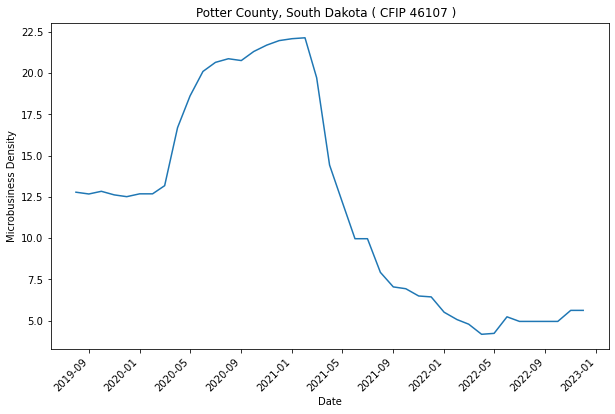

In [28]:
cfip = 46107
plot_county(cfip)

In [29]:
# if cfip in tmp1.cfips.unique() : 
#     print("clipped")
#     p,d,q = results["-1"][str(cfip)]["best_params_clipped"]
# else: 
#     print("original")
#     p,d,q = results["-1"][str(cfip)]["best_params_original"]
# p,d,q

In [30]:
# data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values[-15:] # use last 15 values only
# data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"]
# model = sm.tsa.ARIMA(data[:-2], order=(p, d, q))
# results1 = model.fit()
# y_pred = np.concatenate([results1.predict()[1:], results1.forecast(2)])
# smape_val = smape(results1.predict()[1:],data[1:])
# smape_val

In [31]:
# y_pred = np.concatenate([results1.predict().values, results1.forecast(5)])
# x = list(range(len(y_pred)))
# dates = pd.date_range(start='2019-08-01', end='2023-03-01', freq='MS')
# dates = [date.strftime('%Y-%m-%d') for date in dates]
# location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
# plt.figure(figsize=(10,6))
# plt.plot(x[:len(data)],y_pred[:len(data)], label="Prediction")
# plt.plot(x[:len(data)],data.values, label="True")
# plt.plot(x[len(data):],y_pred[len(data):], label="Forecast")

# # Set the axis labels and title
# plt.xlabel('Date')
# plt.ylabel('Microbusiness Density')
# plt.title(f'{location} ( CFIP {cfip} ) ')
# plt.xticks(x[::2], dates[::2], rotation=45)
# plt.legend()
# plt.show()

In [32]:
# dates

In [33]:
def get_cluster(cfip):
    for key in clusters: 
        if cfip in clusters[key]: 
            return key

def train_arima_model(cfip):
    cluster_id = get_cluster(cfip)
    result = results[cluster_id][str(cfip)]
    if result["val_original_smape"] <= result["val_clipped_smape"]: 
        p,d,q = result["best_params_original"]
        data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
    else: 
        p,d,q = result["best_params_clipped"]
        data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"][-15:].values
    
    model = sm.tsa.ARIMA(data[:-2], order=(p, d, q))
    results1 = model.fit()
    train_y_pred = results1.predict()[1:]
    train_y = data[1:-2]
    test_y_pred = results1.forecast(2)
    test_y = data[-2:]
    
    
    train_smape = smape(train_y, train_y_pred)
    test_smape = smape(test_y, test_y_pred)
    train_rmse = np.sqrt(mean_squared_error(train_y,train_y_pred))
    test_rmse = np.sqrt( mean_squared_error(test_y, test_y_pred))
    
    return train_smape, test_smape, train_rmse, test_rmse

        
    

In [35]:
best_smape_error = 0
good_counter = 0 

In [36]:
# if key  = -1 then  Unclustered, otherwise clustered 

best_performing_counties_arima = []
best_performing_counties_train_errors = []
best_performing_counties_test_errors = []
worst_performing_counties_arima = []
worst_errors_arima = []
df = pd.DataFrame(columns = ["Cluster", "Size", "Train SMAPE", "Validation SMAPE", "Train RMSE", "Validation RMSE"])
for index in [0,1,2,3,4,5,6,-1]:
    index = str(index)
    print(f"Cluster {index}")
    
    if len(clusters[index]) == 0 : 
        continue

    train_rmse_arr = []
    test_rmse_arr = []
    train_smape_arr = []
    test_smape_arr = []
    for cfip in tqdm(clusters[index]): 
        train_smape, test_smape, train_rmse, test_rmse = train_arima_model(cfip)
        # check if any model fails 
        if test_smape <= 0.02 : 
            if train_smape <= 0.05 : 
                best_smape_error += test_smape 
                good_counter += 1
            best_performing_counties_train_errors.append(train_smape)
            best_performing_counties_test_errors.append(test_smape)
            best_performing_counties_arima.append(cfip)
        else: 
            worst_performing_counties_arima.append(cfip)
            worst_errors_arima.append(test_smape)
            
        if not np.isnan(test_smape) : 
            train_rmse_arr.append(train_rmse)
            test_rmse_arr.append(test_rmse)
            train_smape_arr.append(train_smape)
            test_smape_arr.append(test_smape)
        else: 
            print(cfip)
    
    df.loc[len(df.index)] = [index, len(train_smape_arr), round(np.mean(train_smape_arr),3), round(np.mean(test_smape_arr),3), round(np.mean(train_rmse_arr),3), round(np.mean(test_rmse_arr),3) ]

Cluster 0


100%|████████████████████████████████████████████████████████████████████████████████| 713/713 [02:27<00:00,  4.85it/s]


Cluster 1
Cluster 2
Cluster 3
Cluster 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s]


Cluster 5


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Cluster 6


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.28it/s]


Cluster -1


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:31<00:00,  5.76it/s]


In [37]:
best_smape_error2 = best_smape_error/good_counter 

In [41]:
best_smape_error2, best_smape_error, good_counter

(0.007249279408663857, 3.6246397043319285, 500)

In [91]:
worst_errors_arima = np.array(worst_errors_arima)
worst_performing_counties_arima = np.array(worst_performing_counties_arima)
best_performing_counties_arima = np.array(best_performing_counties_arima)
best_performing_counties_train_errors = np.array(best_performing_counties_train_errors)
best_performing_counties_test_errors = np.array(best_performing_counties_test_errors)

In [39]:
good_counter

500

### Benchmarking against linear regression

In [44]:
def train_lr_model(cfip, clipped_lr = False, last_n = 12):
    columns = ["pct_bb","median_hh_inc","pct_college", "pct_foreign_born","pct_it_workers"]
    X_cur = mbd_data[mbd_data.cfips == cfip].loc[:,columns]
    time_steps = list( range(len(X_cur)))
    X_cur.insert(0, "time_step", time_steps) 
    y_cur = mbd_data[ mbd_data.cfips == cfip ].loc[:,"microbusiness_density"]
    
    if clipped_lr: 
        X_cur = X_cur[-last_n:]
        y_cur = y_cur[-last_n:]

    X_train, X_test, y_train, y_test = train_test_split(X_cur, y_cur, test_size=0.1, shuffle=False)
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_smape = smape(y_train_pred, y_train)

    y_test_pred = model.predict(X_test)
    test_smape = smape(y_test_pred, y_test)

    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))

    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_pred, y_test))
    
    return train_smape, test_smape, train_rmse, test_rmse


In [45]:
# if key  = -1 then  Unclustered, otherwise clustered 

best_performing_counties_lr = []
worst_performing_counties_lr = []
worst_errors_lr = []
df = pd.DataFrame(columns = ["Cluster", "Size", "Train SMAPE", "Validation SMAPE", "Train RMSE", "Validation RMSE", "0.02","0.03","0.05"])
for index in [0,1,2,3,4,5,6,-1]:
    index = str(index)
    print(f"Cluster {index}")
    
    if len(clusters[index]) == 0 : 
        continue

    train_rmse_arr = []
    test_rmse_arr = []
    train_smape_arr = []
    test_smape_arr = []
    for cfip in tqdm(clusters[index]): 
        train_smape, test_smape, train_rmse, test_rmse = train_lr_model(cfip)
        if test_smape <0.02 : 
            best_performing_counties_lr.append(cfip)
        else:
            new_train_smape, new_test_smape, new_train_rmse, new_test_rmse = train_lr_model(cfip,clipped_lr = True)
            if new_test_smape < 0.02 : 
                best_performing_counties_lr.append(cfip)
                train_smape, test_smape, train_rmse, test_rmse = new_train_smape, new_test_smape, new_train_rmse, new_test_rmse            
        train_rmse_arr.append(train_rmse)
        test_rmse_arr.append(test_rmse)
        train_smape_arr.append(train_smape)
        test_smape_arr.append(test_smape)
        
        if test_smape > 0.02 :
            worst_performing_counties_lr.append(cfip)
            worst_errors_lr.append(test_smape)            
    
    test_smape = np.array(test_smape_arr)
    percent_error_2 = len(test_smape[ (test_smape < 0.02) ])/len(test_smape)*100
    percent_error_3 = len(test_smape[ (test_smape < 0.03) ])/len(test_smape)*100
    percent_error_5 = len(test_smape[ (test_smape < 0.05) ])/len(test_smape)*100
    
    df.loc[len(df.index)] = [index, len(clusters[index]), round(np.mean(train_smape_arr),3), round(np.mean(test_smape_arr),3), round(np.mean(train_rmse_arr),3), round(np.mean(test_rmse_arr),3), 
                             percent_error_2,percent_error_3,percent_error_5 ]



Cluster 0


100%|████████████████████████████████████████████████████████████████████████████████| 713/713 [00:20<00:00, 34.57it/s]


Cluster 1
Cluster 2
Cluster 3
Cluster 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 32.02it/s]


Cluster 5


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s]


Cluster 6


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.40it/s]


Cluster -1


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:05<00:00, 34.38it/s]


In [46]:
worst_errors_lr = np.array(worst_errors_lr)
worst_performing_counties_lr = np.array(worst_performing_counties_lr)

In [47]:
worst_errors_lr[worst_errors_lr > .5]

array([2.        , 0.83436641, 1.34155409, 0.53653549, 1.11906507,
       0.61590412, 2.        , 0.6127573 , 0.64477172, 1.07965551,
       0.50154851, 0.5611257 , 0.86089384, 1.75755944, 1.2102272 ,
       0.67814854, 0.51215381, 0.64593209, 0.5289317 , 0.84786435])

In [48]:
worst_performing_counties_lr[worst_errors_lr > .5]

array([28055,  1133,  5055,  6115, 12001, 15005, 17075, 18025, 18073,
       20065, 20135, 26095, 29063, 32510, 38039, 46075, 46107, 47095,
       48155, 54017])

In [54]:
len(worst_performing_counties_lr), np.intersect1d(worst_performing_counties_lr, best_performing_counties_arima).shape

(877, (538,))

(array([328., 175., 134.,  68.,  42.,  32.,  21.,   7.,   8.,   7.]),
 array([0.02001324, 0.04298495, 0.06595666, 0.08892836, 0.11190007,
        0.13487178, 0.15784348, 0.18081519, 0.20378689, 0.2267586 ,
        0.24973031]),
 <BarContainer object of 10 artists>)

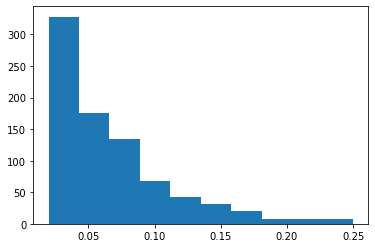

In [57]:
plt.hist(worst_errors_lr[worst_errors_lr < 0.25])

(array([172.,  80.,  29.,  21.,   9.,   2.,   3.,   2.,   6.,   3.]),
 array([0.02009547, 0.0409116 , 0.06172774, 0.08254387, 0.10336001,
        0.12417614, 0.14499228, 0.16580841, 0.18662455, 0.20744068,
        0.22825682]),
 <BarContainer object of 10 artists>)

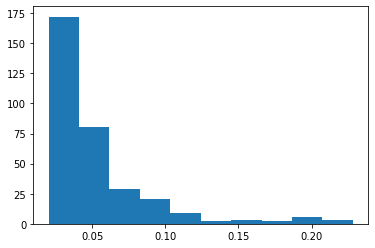

In [58]:
plt.hist(worst_errors_arima[worst_errors_arima < 0.25])

In [60]:
np.mean(worst_errors_arima), np.mean(worst_errors_lr)

(0.07172025182628576, 0.09675079652029925)

In [61]:
len(best_performing_counties_arima)

555

(array([519.,  28.,   5.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00381175, 0.05800887, 0.11220599, 0.16640312, 0.22060024,
        0.27479737, 0.32899449, 0.38319161, 0.43738874, 0.49158586,
        0.54578299]),
 <BarContainer object of 10 artists>)

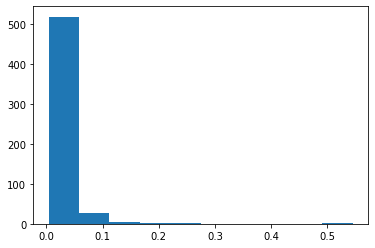

In [64]:
plt.hist(best_performing_counties_train_errors[best_performing_counties_train_errors > 0.02])


In [84]:
best_performing_counties_train_errors[best_performing_counties_train_errors < 0.05].shape, best_performing_counties_arima.shape

((500,), (555,))

Text(0.5, 1.0, 'ARIMA : Histogram of Train Errors')

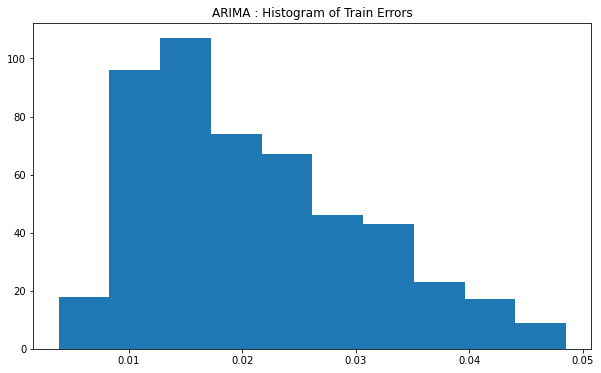

In [95]:
plt.figure(figsize=(10,6))
plt.hist(best_performing_counties_train_errors[best_performing_counties_train_errors < 0.05])
plt.title("ARIMA : Histogram of Train Errors")

Text(0.5, 1.0, 'ARIMA : Histogram of Test Errors')

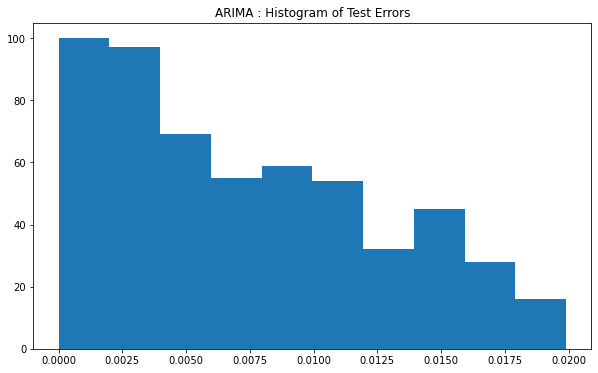

In [94]:
plt.figure(figsize=(10,6))
plt.hist(best_performing_counties_test_errors[best_performing_counties_test_errors < 0.05])
plt.title("ARIMA : Histogram of Test Errors")

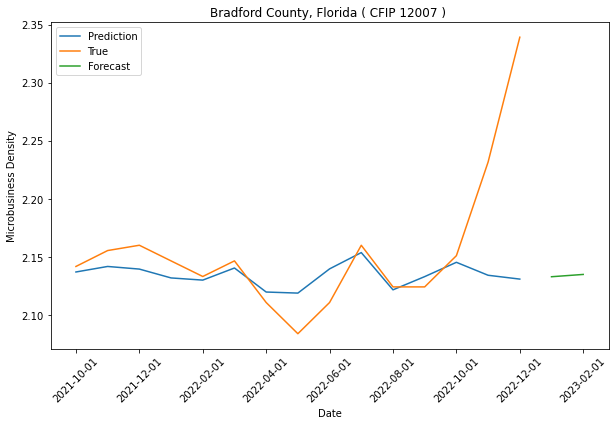

In [118]:
cfip = worst_performing_counties_arima[16]
cluster_id = get_cluster(cfip)
result = results[cluster_id][str(cfip)]
dates = pd.date_range(start='2019-08-01', end='2023-03-01', freq='MS')
dates = [date.strftime('%Y-%m-%d') for date in dates]
if result["val_original_smape"] <= result["val_clipped_smape"]: 
    p,d,q = result["best_params_original"]
    data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
else: 
    p,d,q = result["best_params_clipped"]
    data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"][-15:].values
    dates = dates[-15-3:]

model = sm.tsa.ARIMA(data[:-2], order=(p, d, q))
results1 = model.fit()
train_y_pred = results1.predict()[1:]
train_y = data[1:-2]
test_y_pred = results1.forecast(2)
test_y = data[-2:]   

y_pred = np.concatenate([train_y_pred, results1.forecast(5)])
x = list(range(len(y_pred)))
location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
plt.figure(figsize=(10,6))
plt.plot(x[:len(data)],y_pred[:len(data)], label="Prediction")
plt.plot(x[:len(data)],data, label="True")
plt.plot(x[len(data):],y_pred[len(data):], label="Forecast")

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Microbusiness Density')
plt.title(f'{location} ( CFIP {cfip} ) ')
plt.xticks(x[::2], dates[::2], rotation=45)
plt.legend()
plt.show()





In [101]:
len(x), len(y_pred)

(17, 17)

### Do forecasting using ARIMA

In [48]:
def get_cluster(cfip):
    for key in clusters: 
        if cfip in clusters[key]: 
            return key

def train_arima_model(cfip):
    cluster_id = get_cluster(cfip)
    result = results[cluster_id][str(cfip)]
    if result["val_original_smape"] <= result["val_clipped_smape"]: 
        p,d,q = result["best_params_original"]
        data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
    else: 
        p,d,q = result["best_params_clipped"]
        data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"][-15:].values
    
    model = sm.tsa.ARIMA(data[:-2], order=(p, d, q))
    results1 = model.fit()
    train_y_pred = results1.predict()[1:]
    train_y = data[1:-2]
    test_y_pred = results1.forecast(2)
    test_y = data[-2:]
    
    
    train_smape = smape(train_y, train_y_pred)
    test_smape = smape(test_y, test_y_pred)
    train_rmse = np.sqrt(mean_squared_error(train_y,train_y_pred))
    test_rmse = np.sqrt( mean_squared_error(test_y, test_y_pred))

    model = sm.tsa.ARIMA(data, order=(p, d, q))
    results1 = model.fit()
    y_forecast = results1.forecast(3)
    
    return np.concatenate([train_y,test_y]), np.concatenate([train_y_pred, test_y_pred,y_forecast])

        
    

In [49]:
train_arima_model(1035)

(array([0.72911394, 0.73924053, 0.76962024, 0.75949365, 0.79083443,
        0.77055663, 0.77055663, 0.78069556, 0.75027883, 0.79083443,
        0.79083443, 0.79083443, 0.79083443, 0.84152895, 0.79083443,
        0.78069556, 0.80694586, 1.011236  , 1.011236  , 2.0122573 ,
        2.1246169 , 2.1246169 , 2.1144025 , 2.1552606 , 1.2155261 ,
        1.1950971 , 1.1746681 , 1.1950971 , 1.1993383 , 1.2096775 ,
        1.17866   , 1.1476427 , 1.1373036 , 1.0545906 , 1.1476427 ,
        1.1579818 , 1.1373036 , 1.095947  , 1.095947  , 1.013234  ]),
 array([0.787584  , 0.78073022, 0.79525256, 0.82318311, 0.81381628,
        0.83674733, 0.82270062, 0.81753938, 0.82914242, 0.80337603,
        0.83546491, 0.84236826, 0.83685842, 0.83634976, 0.88215138,
        0.84052583, 0.82100778, 0.85090777, 1.03594536, 1.04435949,
        1.90264125, 2.06895382, 1.94030989, 1.91860807, 1.9747826 ,
        1.14607846, 1.05786715, 1.17026198, 1.18771938, 1.17591167,
        1.18422138, 1.15927437, 1.12826868, 1.

In [86]:
# cluster_id = get_cluster(cfip)
# result = results[cluster_id][str(cfip)]
# if result["val_original_smape"] <= result["val_clipped_smape"]: 
#     p,d,q = result["best_params_original"]
#     data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
# else: 
#     p,d,q = result["best_params_clipped"]
#     data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"][-15:].values
#     dates = dates[-15-3:]

# model = sm.tsa.ARIMA(data[:-2], order=(p, d, q))
# results1 = model.fit()
# train_y_pred = results1.predict()[1:]
# train_y = data[1:-2]
# test_y_pred = results1.forecast(2)
# test_y = data[-2:]   

best_smape_error = 0 
good_counter = 0 
poor_counter = 0 
for key in clusters: 
    for cfip in clusters[key]:
        data, y_pred = train_arima_model(cfip)
        dates = pd.date_range(start='2019-08-01', end='2023-03-01', freq='MS')
        dates = [date.strftime('%Y-%m-%d') for date in dates]
        dates = dates[-len(y_pred):]
        x = list(range(len(y_pred)))
        location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
        plt.figure(figsize=(10,6))
        plt.plot(x[:len(data)],y_pred[:len(data)], label="Prediction")
        plt.plot(x[:len(data)],data, label="True")
        plt.plot(x[len(data):],y_pred[len(data):], label="Forecast")

        # Set the axis labels and title
        plt.xlabel('Date')
        plt.ylabel('Microbusiness Density')
        plt.title(f'{location} ( CFIP {cfip} ) ')
        plt.xticks(x[::4], dates[::4], rotation=45)
        plt.legend()
        if cfip in best_performing_counties_arima2:
            plt.savefig(f"images/arima_results/good_fit/fig_{good_counter}")
            good_counter += 1
            best_smape_error += smape(y_true[-1:],y_pred[:len(y_true)][-1:])
        else: 
            plt.savefig(f"images/arima_results/poor_fit/fig_{poor_counter}")
            poor_counter += 1
#         plt.show()
        plt.close()





LinAlgError: LU decomposition error.

In [52]:
len(best_performing_counties_arima) , len(worst_performing_counties_arima)

(555, 342)

In [83]:
best_performing_counties_train_errors = np.array(best_performing_counties_train_errors)
best_performing_counties_arima = np.array(best_performing_counties_arima)

In [66]:
best_performing_counties_train_errors[best_performing_counties_train_errors < 0.05].shape

(500,)

In [84]:
best_performing_counties_arima2 = best_performing_counties_arima[best_performing_counties_train_errors < 0.15]

2580